# Roman Yakymiv KN-410 #6

  - Побудувати CNN на основі ResNet-50 для класифікації зображень на основі датасету fashion-mnist.
  - Зробити налаштування моделі для досягнення необхідної точності.
  - На базі Siamese networks побудувати систему для пошуку подібних зображень в датасеті fashion-mnist.
  - Візуалізувати отримані результати t-SNE.

## Preprocessing

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [2]:
tf.config.run_functions_eagerly(True)

In [3]:
img_shape =  np.concatenate((test_images.shape[1:], [1]))
CLASSES = len(np.unique(test_labels))
EPOCH=17
BS = 128

train_images = train_images / 255.0
test_images = test_images / 255.0

In [4]:
import random

def create_pairs(x, digit_indices):
    '''
    Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(CLASSES)]) - 1
    for d in range(CLASSES):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, CLASSES)
            dn = (d + inc) % CLASSES
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

def make_pair_dataset(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(CLASSES)]
    pairs, y = create_pairs(images, digit_indices)
    return pairs, y

In [5]:
tr_pairs, tr_y = make_pair_dataset(train_images, train_labels)
te_pairs, te_y = make_pair_dataset(test_images, test_labels)


In [6]:
from sklearn.model_selection import train_test_split

tr_y = tr_y.astype(np.float32)
te_y = te_y.astype(np.float32)

x_tra, x_val, y_tra, y_val = train_test_split(tr_pairs, tr_y, test_size=0.2, stratify=tr_y, random_state=21)

## Feature Model

In [7]:
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = tf.keras.layers.Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = tf.keras.layers.Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  # third block activation used after adding the input
  x = tf.keras.layers.Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = tf.keras.layers.Add()([x, x_skip])
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  return x

In [8]:
def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = tf.keras.layers.Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid')(x)
  # when s = 2 then it is like downsizing the feature map
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  # second block
  x = tf.keras.layers.Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  #third block
  x = tf.keras.layers.Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # shortcut 
  x_skip = tf.keras.layers.Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid')(x_skip)
  x_skip = tf.keras.layers.BatchNormalization()(x_skip)

  # add 
  x = tf.keras.layers.Add()([x, x_skip])
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  return x

In [9]:
def Resnet50():

  input_im = tf.keras.layers.Input(shape=img_shape)
  x = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = tf.keras.layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = tf.keras.layers.AveragePooling2D((2, 2), padding='same')(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(CLASSES, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = tf.keras.Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [11]:
feature_model = Resnet50()

# Siamese model

In [12]:
img_a_in = tf.keras.layers.Input(shape =img_shape, name = 'ImageA_Input')
img_b_in = tf.keras.layers.Input(shape =img_shape, name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = tf.keras.layers.concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = tf.keras.layers.Dense(16, activation = 'linear')(combined_features)
combined_features = tf.keras.layers.BatchNormalization()(combined_features)
combined_features = tf.keras.layers.Activation('relu')(combined_features)
combined_features = tf.keras.layers.Dense(4, activation = 'linear')(combined_features)
combined_features = tf.keras.layers.BatchNormalization()(combined_features)
combined_features = tf.keras.layers.Activation('relu')(combined_features)
combined_features = tf.keras.layers.Dense(1, activation = 'sigmoid')(combined_features)


In [14]:
similarity_model = tf.keras.Model(inputs = [img_a_in, img_b_in], outputs=[combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 Resnet50 (Functional)          (None, 10)           23601930    ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['Resnet50[0][0]',

# Training

In [15]:
similarity_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['mae'])

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Classroom/similarity_model",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.0001)

In [17]:
history = similarity_model.fit([x_tra[:,0], x_tra[:, 1]], y_tra, epochs=EPOCH, batch_size=BS, 
                    validation_data=([x_val[:, 0], x_val[:, 1]], y_val), callbacks=[early_stopping, save_model, reduce_lr])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/17
750/750 [==============================] - ETA: 0s - loss: 0.6672 - mae: 0.4747

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Classroom/similarity_model/assets


750/750 [==============================] - 438s 567ms/step - loss: 0.6672 - mae: 0.4747 - val_loss: 0.6843 - val_mae: 0.4832 - lr: 0.0010
Epoch 2/17
750/750 [==============================] - 390s 521ms/step - loss: 0.6736 - mae: 0.4828 - val_loss: 0.6922 - val_mae: 0.4986 - lr: 0.0010
Epoch 3/17
750/750 [==============================] - 381s 508ms/step - loss: 0.6918 - mae: 0.4988 - val_loss: 0.6915 - val_mae: 0.4987 - lr: 2.0000e-04
Epoch 4/17
750/750 [==============================] - 372s 496ms/step - loss: 0.6906 - mae: 0.4981 - val_loss: 0.6856 - val_mae: 0.4947 - lr: 1.0000e-04


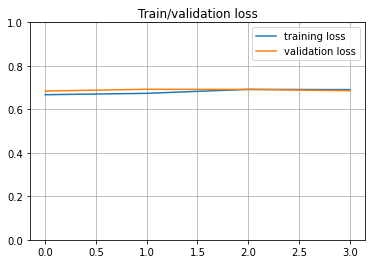

In [18]:
import matplotlib.pyplot as plt


def plot_history(history):
    plt.title('Train/validation loss')
    plt.plot(history.history['loss'], label = 'training loss')
    plt.plot(history.history['val_loss'], label = 'validation loss')
    plt.grid()
    plt.legend()
    plt.ylim(0,1)
    plt.show()

plot_history(history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


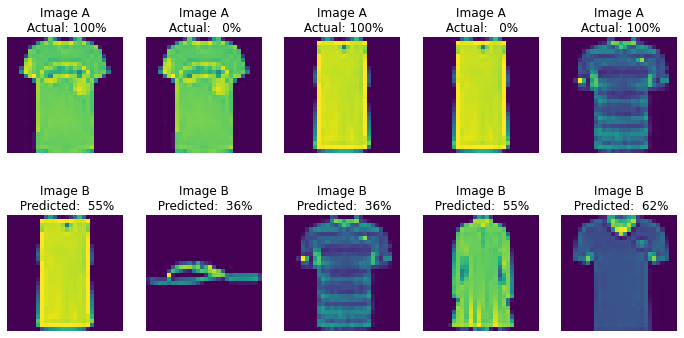

In [19]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim  = te_pairs[:nb_examples, 0], te_pairs[:nb_examples, 1], te_y[:nb_examples]

    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):

        ax1.imshow(c_a)
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b)
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
    # a completely untrained model
_ = show_model_output(5)

# Function for similar images search

In [20]:
def find_similar(image, images, count=3, threshold=50):
    pv_a, pv_b = np.reshape([image]*len(images), (len(images), 28,28)), np.reshape(images, (len(images), 28,28))
    pred_sim = similarity_model.predict([pv_a, pv_b]).ravel()
    indxs = np.argsort(pred_sim)[::-1][:count]
    
    fig, m_axs = plt.subplots(2, count, figsize = (12, 6))
    i = 0
    for c_a, (ax1, ax2) in zip(pv_a[:count], m_axs.T):
        
        ax1.imshow(c_a)
        ax1.set_title('Input image\n')
        ax1.axis('off')
        ax2.imshow(pv_b[indxs[i]])
        ax2.set_title('Similar\n Predicted: %3.0f%%' % (100*pred_sim[indxs[i]]))
        ax2.axis('off')
        i += 1


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


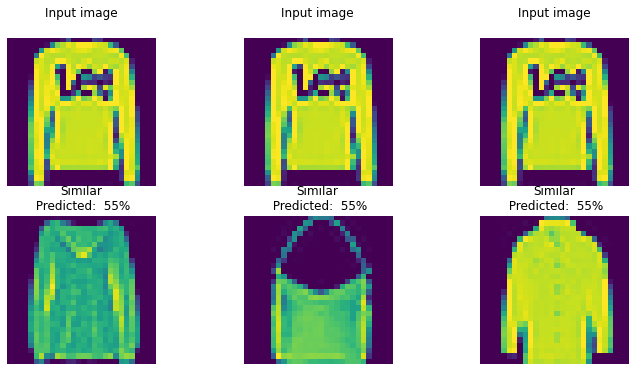

In [21]:
find_similar(test_images[1], images=test_images[1:50])

# t-SNE

In [22]:
x_test_features = feature_model.predict(test_images, verbose = True,batch_size=BS)

 1/79 [..............................] - ETA: 8s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


79/79 [==============================] - 7s 91ms/step


In [23]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=500,
                verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.012s...
[t-SNE] Computed neighbors for 10000 samples in 0.364s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 11.372s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 64.8048553, gradient norm = 0.0380215 (50 iterations in 3.799s)
[t-SNE] Iteration 100: error = 56.5684433, gradient norm = 0.0047110 (50 iterations in 3.586s)
[t-SNE] Iteration 150: error = 53.8233719, gradient norm = 0.0039447 (50 iterations in 3.303s)
[t-SNE] Iteration 200: error = 52.1555405, gradient norm = 0.0022907 (50 iterations in 3.140s)
[t-SNE] Iteration 250: error = 51.5759659, gradient norm = 0.0030603 (50 iterations in 3.207s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.575966
[t-SNE] Iteration 300: error = 1.1644671, gradient norm = 0.0010558 (50 iterations in 3.125s)
[t-SNE] Iteration 350: error = 0.8307647, gradient norm = 0.0004566 (50 iterations in 3.091s)
[t-SNE] Iteration 400: error = 0.6828312, gradient norm = 0.0002629 (50 iterations in 3.068s)
[t-SNE] Iteration 450: error = 0.6041011, gradient norm = 0.0001734 (50 iterations in 3.048s)
[t-SNE] Iteration 500: error = 0.5569665, gradient norm = 0.0001242 (50 

In [24]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

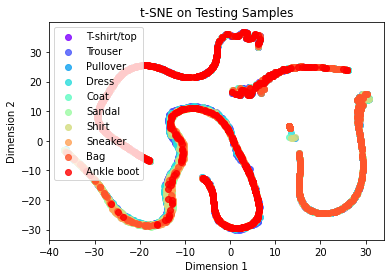

In [25]:
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(test_labels == c_group), 0],
    tsne_features[np.where(test_labels == c_group), 1],
    marker='o',
    color=c_color,
    linewidth='1',
    alpha=0.8,
    label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)